In [264]:
%matplotlib inline

In [1]:
from tika import parser
import re
#import classifier as spanish_sentiment_analysis
#from spellchecker import SpellChecker

# Preprocessing

In [3]:
pdf_path = "./dataset/telegram_gate.pdf"

raw = parser.from_file(pdf_path)

pdf_content = raw['content']

2019-07-24 18:40:17,296 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.19/tika-server-1.19.jar.md5 to /tmp/tika-server.jar.md5.
2019-07-24 18:40:17,725 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.19/tika-server-1.19.jar to /tmp/tika-server.jar.
2019-07-24 18:42:02,393 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


In [4]:
# f = open("telegramgate.txt","w")
# f.write(pdf_content)
# f.close()

The text contains a lot of new lines. Let's remove them.

In [6]:
pdf_content = pdf_content.strip("\n")

In [7]:
print(pdf_content[0:500])

1/20/2019 Telegram Web 

WRF 12 members 

Friday, November 30, 2018 

Ramon Rosario admin 6:07:05 AM 
RR 

6:08:21 AM 

https://web .telegram .org/#/im?p=s1209505337 _ 15413785455230905639 1/889 



1/20/2019 

RR 

Edwin Miranda admin 

En PRINT! 

Ramon Rosario admin 

R Rossello admin 

lComo se col6 eso? 

https ://web .telegram .org/#/im?p=s1209505337 _ 15413785455230905639 

Telegram Web 

6:18:33 AM 

6:19:47 AM 

6:19:47 AM 

6:21:01 AM 

6:23:32 AM 

2/889 



1/20/2019 

AO 

RR 

Alfo


The date 1/20/2019 and the string "Telegram Web" appear at the beginning of every page, which most likely implies that the Telegram conversation was downloaded on that date, January 20 of 2019.  

At the end of every page there is a telegram URL https://web.telegram.org/#/im?p=s1209505337_15413785455230905639 and the page you are on out of all pages in the PDF.

We can use the page number for keeping track of the page in the PDF for which a message appears, so we should keep that. But the date and string "Telegram Web" at the top and the link at the bottom of every page should be removed, it is not useful to the analysis.

In [8]:
# Remove "Telegram Web"
pdf_content = pdf_content.replace("Telegram Web", "")

# Remove the date "1/20/2019"
pdf_content = pdf_content.replace("1/20/2019", "")

# Remove the telegram URL which appears at the end of every page
# Create a regular expression to match different variations of the link which differ by extra empty spaces
regex = re.compile(r'https( )*:(\/|1)(\/|1)web( )*\.telegram( )*\.org\/#\/im\?p=s1209505337( )*_( )*15413785455230905639')

# Remove strings that match the regex
pdf_content = re.sub(regex, "", pdf_content)

In [9]:
print(pdf_content[:400])

  

WRF 12 members 

Friday, November 30, 2018 

Ramon Rosario admin 6:07:05 AM 
RR 

6:08:21 AM 

 1/889 



 

RR 

Edwin Miranda admin 

En PRINT! 

Ramon Rosario admin 

R Rossello admin 

lComo se col6 eso? 

 

 

6:18:33 AM 

6:19:47 AM 

6:19:47 AM 

6:21:01 AM 

6:23:32 AM 

2/889 



 

AO 

RR 

Alfonso Orona admin 

Buen dfa!!! 

 

Cifra de Asesinatos para hoy viernes, 30 de noviembre


There are various time stamps which do not align with any messages.  
Here we will assume that the time in which a message was sent is unimportant to the analysis, and thus will be removed.

In [10]:
# Create regex for matching timestamps
regex = re.compile(r'[0-9][0-9]?:[0-9][0-9]( )?:[0-9][0-9]( )?(A|P)M')

# Remove timestamps
pdf_content = re.sub(regex, "", pdf_content)

In [11]:
print(pdf_content[:300])

  

WRF 12 members 

Friday, November 30, 2018 

Ramon Rosario admin  
RR 

 

 1/889 



 

RR 

Edwin Miranda admin 

En PRINT! 

Ramon Rosario admin 

R Rossello admin 

lComo se col6 eso? 

 

 

 

 

 

 

 

2/889 



 

AO 

RR 

Alfonso Orona admin 

Buen dfa!!! 

 

Cifra de Asesinatos par


We have a lot of empty new lines again. `.strip("\n")` did not work this time.  
We will wait to remove the empty lines when we create a list from the lines in `pdf_content`.  

Notie that the text contains various 2 letter accronyms. When revisiting the PDF file, you will notice that these accronyms correspond to the users participating in the chat. We will first identify the users participating in the chat before removing these accronyms, which do not play a role in the conversation.

At the moment I can't identify any more strings to remove from the plain text, so let's create a list from the `pdf_content` and start extracting information.

In [12]:
# Create a list of sentences from document

pdf_lines = pdf_content.split("\n")

In [13]:
pdf_lines[0:10]

['  ',
 '',
 'WRF 12 members ',
 '',
 'Friday, November 30, 2018 ',
 '',
 'Ramon Rosario admin  ',
 'RR ',
 '',
 ' ']

In [14]:
# Remove empty string elements

regex = re.compile(r'^( )*$')

pdf_lines = [line for line in pdf_lines if not regex.match(line)]

In [15]:
pdf_lines[0:10]

['WRF 12 members ',
 'Friday, November 30, 2018 ',
 'Ramon Rosario admin  ',
 'RR ',
 ' 1/889 ',
 'RR ',
 'Edwin Miranda admin ',
 'En PRINT! ',
 'Ramon Rosario admin ',
 'R Rossello admin ']

In [16]:
len(pdf_lines)

30762

# Organize Information

In order to organize/structure the information from the PDF, let's identify the chat members and which messages were sent per member.

When reviewing the PDF's plain text, you can notice that the lines containing an admin user's name contain the term 'admin'. Let's issolate the lines which contain this term, in order to identify the admin users in the chat.

We could use text formatting to automatically identify all members present in the chat, but at least I was not able to read in the PDF document with formatting included (I read it in using the Tika CLI and the tags --xml and --html but neither kept the original formatting of the PDF). 

So we will have to do with identifying the admins automatically and identifying the other members manually (for now ...)

In [17]:
# Get admin chat members by keeping unique lines which contain the word 'admin'
admin_chat_members = set(line.strip() for line in pdf_lines if ' admin ' in line)

In [18]:
admin_chat_members

{'Alfonso Orona admin',
 'Alfonso Orona admin edited',
 'Carlos Bermudez admin',
 'Ch Sobri admin',
 'Ch Sobri via @gif admin',
 'Edwin Miranda admin',
 'Edwin Miranda admin  --~ Edwin Miranda',
 'Edwin Miranda admin --Super! Anthony O. Maceira layas Photo',
 'Edwin Miranda admin --~~ @ - Carlos Bermudez Photo',
 'Edwin Miranda admin -~-',
 'Edwin Miranda via @gif admin',
 'F do admin',
 'Fdo admin',
 'Fdo via@gif admin',
 'R Rossello admin',
 'R Rossello admin edited',
 'R Russello admin',
 "Rafael Cerame D'Acosta admin",
 'Ramon Rosario admin'}

In [19]:
# Clean the admin chat members list by removing ' admin' and any text after

admin_chat_members_cleaned = set()

for element in admin_chat_members:
    
    index = element.find(' admin') # locate where in the line is the string ' admin' 
    
    admin_chat_members_cleaned.add(element[:index])
    
admin_chat_members = admin_chat_members_cleaned

In [20]:
admin_chat_members

{'Alfonso Orona',
 'Carlos Bermudez',
 'Ch Sobri',
 'Ch Sobri via @gif',
 'Edwin Miranda',
 'Edwin Miranda via @gif',
 'F do',
 'Fdo',
 'Fdo via@gif',
 'R Rossello',
 'R Russello',
 "Rafael Cerame D'Acosta",
 'Ramon Rosario'}

In [21]:
# Remove the elements in admin_chat_members which contain the text 'gif', they are repeated

admin_chat_members = [member for member in admin_chat_members if not('gif' in member)]
admin_chat_members

["Rafael Cerame D'Acosta",
 'R Rossello',
 'R Russello',
 'Alfonso Orona',
 'F do',
 'Ch Sobri',
 'Carlos Bermudez',
 'Edwin Miranda',
 'Fdo',
 'Ramon Rosario']

In [22]:
# Two elements in the admin_chat_members list seem to be typos, remove them

admin_chat_members.remove("R Russello") # assuming it's 'R Rosello' read incorrectly by Tika
admin_chat_members.remove("Fdo") # assuming it's 'F do' read incorrectly by Tika

In [23]:
admin_chat_members

["Rafael Cerame D'Acosta",
 'R Rossello',
 'Alfonso Orona',
 'F do',
 'Ch Sobri',
 'Carlos Bermudez',
 'Edwin Miranda',
 'Ramon Rosario']

In [24]:
# Replace 'Fdo' with 'F do'
# Replace 'R Russello' with 'R Rosello'

pdf_lines_fixed = []

for line in pdf_lines:
    
    new_line = line
    
    if 'R Russello' in line:
        new_line = line.replace('R Russello', 'R Rosello')
        
    if 'Fdo' in line:
        new_line = line.replace('Fdo', 'F do')
        
    pdf_lines_fixed.append(new_line)
        
pdf_lines = pdf_lines_fixed

In [25]:
len(admin_chat_members)

8

From going through the PDF document manually, I found that the non-admin members in the chat are:
* Raul Maldonado
* Anthony O. Maceira Zayas
* Ricardo Llerandi
* LuisG
  
This amounts to a total of 12 chat members, as stated at the beggining of the PDF.
  
How do we find these non-admin users without searching manually? Chat members appear in bold, could we have Tika keep text formatting?

In [26]:
# Make a consolidated chat members list

nonadmin_chat_members = [
    "Raul Maldonado",
    "Anthony O. Maceira Zayas",
    "Ricardo Llerandi",
    "LuisG"
]

all_chat_members = admin_chat_members + nonadmin_chat_members

In [27]:
all_chat_members

["Rafael Cerame D'Acosta",
 'R Rossello',
 'Alfonso Orona',
 'F do',
 'Ch Sobri',
 'Carlos Bermudez',
 'Edwin Miranda',
 'Ramon Rosario',
 'Raul Maldonado',
 'Anthony O. Maceira Zayas',
 'Ricardo Llerandi',
 'LuisG']

In [28]:
len(all_chat_members)

12

Now that we know whom the admin chat members are, let's create their acronyms, search for them in pdf_lines, and remove them.

(Just found out that only chat members without profile pictures appear with their name accronym. GAH!)

In [29]:
# Create admin member accronyms

user_acronyms = set()

for chat_member in all_chat_members:
    
    names = chat_member.split(" ")
    names = names[:2] # user accronyms in the PDF have a maximum of 2 letters
    
    acronym = ""
    for name in names:
        acronym += name[0].upper()
    
    user_acronyms.add(acronym)

In [30]:
user_acronyms

{'AO', 'CB', 'CS', 'EM', 'FD', 'L', 'RC', 'RL', 'RM', 'RR'}

From visually searching the PDF, I found that all username accronyms are 2 uppercase letters.  
Let's collect all lines corresponding two 2 uppercase letter accronyms.

Note: not all participating chat members have accronyms by their names.

Don't substract admin accronyms from all potential user accronyms, because other users might share the same accronym.

In [31]:
# Build regular expression for identifying text containing only an accronym and spaces

regular_exp = ""

for acronym in user_acronyms:
    
    regular_exp += acronym + "|"
    
regular_exp = regular_exp[:len(regular_exp)-1]
regular_exp

'AO|RC|RR|CB|CS|L|FD|EM|RM|RL'

In [32]:
regex = re.compile(r'^( )*({regular_exp})( )*$'.format(regular_exp=regular_exp))
regex

re.compile(r'^( )*(AO|RC|RR|CB|CS|L|FD|EM|RM|RL)( )*$', re.UNICODE)

In [33]:
# Remove accronyms from pdf_lines

pdf_lines = [line for line in pdf_lines if not regex.match(line)]

In [34]:
pdf_lines[0:10]

['WRF 12 members ',
 'Friday, November 30, 2018 ',
 'Ramon Rosario admin  ',
 ' 1/889 ',
 'Edwin Miranda admin ',
 'En PRINT! ',
 'Ramon Rosario admin ',
 'R Rossello admin ',
 'lComo se col6 eso? ',
 '2/889 ']

TODO: Page count is wrong :( fiiiiix

In [35]:
# Store the conversation in the list conversation, which will be 
# a list of dictionaries where the dictionary will contain the keys 
# 'chat_member' and 'message'
    
page_number_regex = re.compile(r'( )*[0-9][0-9]?[0-9]?\/889( )*')

# Build date regex
# date example: Friday, November 30, 2018 
weekday = '(Moday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)'
month = '(January|February|March|April|May|June|July|August|September|October|November|December)'
day = '[0-9]?[0-9]'
year = '20[1-2][0-9]'
date_regex = re.compile(r'{weekday}, {month} {day}, {year}'.format(weekday=weekday, 
                                                                   month=month,
                                                                   day=day,
                                                                   year=year))
page_number = 1
date = None
    
conversation = []

current_chat_member = None # which chat member is the current author

new = False # is the detected chat member new (different from previous)?

for line in pdf_lines:
    
    if page_number_regex.match(line):
        page_number += 1
        continue
        
    if date_regex.match(line):
        date = line.strip()
        continue
    
    for chat_member in all_chat_members:
        if chat_member in line:
            # don't add chat member element to conversation
            current_chat_member = chat_member
            new = True
            break
            
    if new:
        new = False
        continue # skip to next iteration
       
    if (current_chat_member != None) and not(current_chat_member in line):
        conversation.append({
            "chat_member": current_chat_member,
            "message": line,
            "page_number": page_number,
            "date": date
        })

In [36]:
conversation

[{'chat_member': 'Edwin Miranda',
  'message': 'En PRINT! ',
  'page_number': 2,
  'date': 'Friday, November 30, 2018'},
 {'chat_member': 'R Rossello',
  'message': 'lComo se col6 eso? ',
  'page_number': 2,
  'date': 'Friday, November 30, 2018'},
 {'chat_member': 'Alfonso Orona',
  'message': 'Buen dfa!!! ',
  'page_number': 3,
  'date': 'Friday, November 30, 2018'},
 {'chat_member': 'Alfonso Orona',
  'message': 'Cifra de Asesinatos para hoy viernes, 30 de noviembre de 2018 ',
  'page_number': 3,
  'date': 'Friday, November 30, 2018'},
 {'chat_member': 'Alfonso Orona',
  'message': '2018-571 ',
  'page_number': 3,
  'date': 'Friday, November 30, 2018'},
 {'chat_member': 'Alfonso Orona',
  'message': '2017-629 ',
  'page_number': 3,
  'date': 'Friday, November 30, 2018'},
 {'chat_member': 'Alfonso Orona',
  'message': '-58 ',
  'page_number': 3,
  'date': 'Friday, November 30, 2018'},
 {'chat_member': 'Alfonso Orona',
  'message': '2016-619 ',
  'page_number': 3,
  'date': 'Friday, No

In [37]:
conversation[len(conversation)-1]

{'chat_member': 'Raul Maldonado',
 'message': 'https://t.co/s914tOijw5 (https://t.co/s914t0ijw5) ',
 'page_number': 888,
 'date': 'Sunday, January 20, 2019'}

In [38]:
len(conversation)

23403

In [39]:
messages_per_user = {user:0 for user in all_chat_members}

for message in conversation:
    messages_per_user[message['chat_member']] += 1
    
messages_per_user

{"Rafael Cerame D'Acosta": 1365,
 'R Rossello': 2770,
 'Alfonso Orona': 2170,
 'F do': 1149,
 'Ch Sobri': 2117,
 'Carlos Bermudez': 4194,
 'Edwin Miranda': 4227,
 'Ramon Rosario': 4125,
 'Raul Maldonado': 454,
 'Anthony O. Maceira Zayas': 195,
 'Ricardo Llerandi': 308,
 'LuisG': 329}

In [43]:
# colors per user
import random

def random_color():
    color = "%06x" % random.randint(0, 0xFFFFFF)
    return color

chat_member_colors = {member:random_color() for member in all_chat_members}
chat_member_colors

{"Rafael Cerame D'Acosta": '773336',
 'R Rossello': '70b954',
 'Alfonso Orona': '33194b',
 'F do': 'b8943c',
 'Ch Sobri': '109327',
 'Carlos Bermudez': '0f0fcf',
 'Edwin Miranda': '789079',
 'Ramon Rosario': '91bdc0',
 'Raul Maldonado': '2caaa7',
 'Anthony O. Maceira Zayas': '44b05e',
 'Ricardo Llerandi': '8a51fa',
 'LuisG': '950d38'}

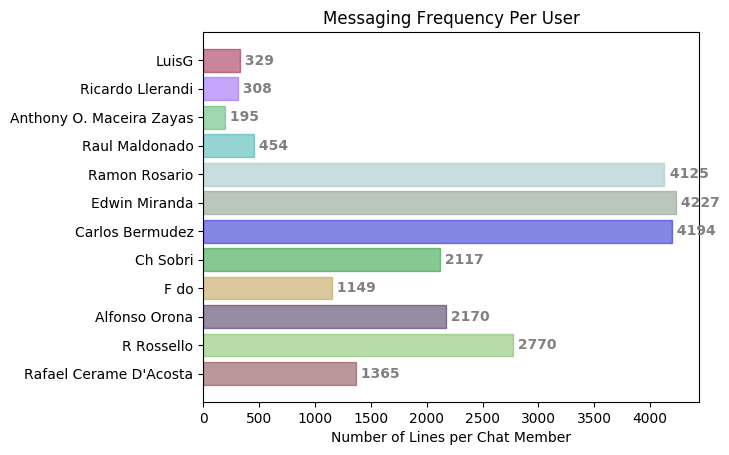

In [44]:
# references:
#   https://pythonspot.com/matplotlib-bar-chart/
#   https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

users = list(messages_per_user.keys())
y_pos = np.arange(len(users))
number_of_lines = list(messages_per_user.values())

fig, ax = plt.subplots()   
barlist = ax.barh(y_pos, number_of_lines, align='center', alpha=0.5)

# color the bars
for i,user_color in enumerate(chat_member_colors.items()):
    user = user_color[0]
    color = user_color[1]
    barlist[i].set_color('#'+color)

plt.yticks(y_pos, users)
plt.xlabel('Number of Lines per Chat Member')
plt.title('Messaging Frequency Per User')

for i, v in enumerate(number_of_lines):
    ax.text(v + 4, i, " "+str(v), color='grey', fontweight='bold',va='center')

plt.show()

In [45]:
html_content = "<html><body><h1>Telegramgate: Abridged</h1>"

page = 1

#print('page {page}'.format(page=page))
html_content += '<p>page {page} </br></p>'.format(page=page)

for msg in conversation:
    
    user = msg['chat_member']
    message = msg['message']
    
    if msg["page_number"] > page:
        page += 1
        #print('page {page}'.format(page=page))
        html_content += '<p></br>page {page}</p>'.format(page=page)
        
    #print('{user}: {message}'.format(user=msg['chat_member'],message=msg['message']))
    color = chat_member_colors[user]
    html_content += '<p><font color="{color}"><b>{user}</b></font>: {message}</p>'.format(color=color,user=user,message=message)
    
html_content += "</body></html>"

In [46]:
filename = "telegramgate_abridged"
html_filename = filename + '.html'

f = open(html_filename,"w")
f.write(html_content)
f.close()

In [ ]:
import pdfkit

pdf_filename = filename + '.pdf'

pdfkit.from_file(html_filename, pdf_filename)

# Text Analysis

Text is in both English and Spanish. Sentiment analysis classifiers are usually made for 1 language.  
We should determine the language of a message before running sentiment analysis, and use a classifier for the specific language.

In [390]:
import classifier as spanish_sentiment_analysis # from here: https://github.com/aylliote/senti-py

In [391]:
clf = spanish_sentiment_analysis.SentimentClassifier()

In [ ]:
x = "Esta muy buena esa pelicula"

print(x + ' ==> %.5f' % clf.predict(x))

In [ ]:
message_scores = dict()

for message in admin_chat_member_messages["R Rossello"]:
    
    message_scores[message] = clf.predict(message)

In [ ]:
message_scores

Tika incorrectly read upside down question marks and some accented letters, such as i and o.   
í = f   
ó = 6  
¿=l  

In [57]:
from spellchecker import SpellChecker # from here: https://pypi.org/project/pyspellchecker/

In [58]:
pdf_lines

['WRF 12 members ',
 'Friday, November 30, 2018 ',
 'Ramon Rosario admin  ',
 'https://web .telegram .org/#/imp=s1209505337 _ 15413785455230905639 1/889 ',
 'Edwin Miranda admin ',
 'En PRINT ',
 'Ramon Rosario admin ',
 'R Rossello admin ',
 'lComo se col6 eso ',
 'https ://web .telegram .org/#/imp=s1209505337 _ 15413785455230905639 ',
 '2/889 ',
 'Alfonso Orona admin ',
 'Buen dfa ',
 'Cifra de Asesinatos para hoy viernes, 30 de noviembre de 2018 ',
 '2018-571 ',
 '2017-629 ',
 '-58 ',
 '2016-619 ',
 '2015-531 ',
 '2014-616 ',
 'Estamos -1,437 en delitos contra la persona para un -19.74 % y ',
 'estamos -6,378 ',
 'en delito contra la propiedad para un -21.85% Comparado con el ',
 '2017, para un total de -7,815. ',
 'Ramon Rosario admin ',
 'https://www.elnuevodia.com/noticias/politica/nota/presidentedela ',
 'asociaciondealcaldesendosaadavidbernierparacorreralagobernacio ',
 'nen2020-2462694/ ',
 '(https://www .elnuevodia.com/noticias/politica/nota/presidentedel ',
 'aasociaciondeal

In [59]:
pdf_lines[0].split(" ")

['WRF', '12', 'members', '']

In [60]:
fixed_pdf_lines = []

spell = {
    "es": SpellChecker(language='es'),
    "en": SpellChecker(language='en')
}

# Remove question and exclamation marks

# pdf_content = (pdf_content.replace('¿','')
#                          .replace('?','')
#                          .replace('¡','')
#                          .replace('!',''))

for line in pdf_lines[:15]:
    
    print("line:",line)
    
    words_in_line = line.split(' ')
    
    words_in_line = [word for word in words_in_line if word != '']
    
    print("line words:",line.split(' '))
    
    misspelled = spell.unknown(words_in_line)
    
    print("misspelled words:",misspelled)
    
    new_line = line
    
    for word in misspelled:
        
        print("word:",word)
        corrected_word = spell.correction(word)
        print("corrected_word:",corrected_word)
        
        new_line = new_line.replace(word,corrected_word)
        
    fixed_pdf_lines.append(new_line)   

line: WRF 12 members 
line words: ['WRF', '12', 'members', '']
misspelled words: {'members', 'wrf'}
word: members
corrected_word: meyers
word: wrf
corrected_word: worf
line: Friday, November 30, 2018 
line words: ['Friday,', 'November', '30,', '2018', '']
misspelled words: {'30,', 'friday,'}
word: 30,
corrected_word: 30
word: friday,
corrected_word: friday
line: Ramon Rosario admin  
line words: ['Ramon', 'Rosario', 'admin', '', '']
misspelled words: {'admin'}
word: admin
corrected_word: amin
line: https://web .telegram .org/#/imp=s1209505337 _ 15413785455230905639 1/889 
line words: ['https://web', '.telegram', '.org/#/imp=s1209505337', '_', '15413785455230905639', '1/889', '']
misspelled words: {'.org/#/imp=s1209505337', '1/889', '.telegram', 'https://web'}
word: .org/#/imp=s1209505337
corrected_word: .org/#/imp=s1209505337
word: 1/889
corrected_word: 1889
word: .telegram
corrected_word: telegrama
word: https://web
corrected_word: https://web
line: Edwin Miranda admin 
line words: ['

In [63]:
pdf_lines[:15]

['WRF 12 members ',
 'Friday, November 30, 2018 ',
 'Ramon Rosario admin  ',
 'https://web .telegram .org/#/imp=s1209505337 _ 15413785455230905639 1/889 ',
 'Edwin Miranda admin ',
 'En PRINT ',
 'Ramon Rosario admin ',
 'R Rossello admin ',
 'lComo se col6 eso ',
 'https ://web .telegram .org/#/imp=s1209505337 _ 15413785455230905639 ',
 '2/889 ',
 'Alfonso Orona admin ',
 'Buen dfa ',
 'Cifra de Asesinatos para hoy viernes, 30 de noviembre de 2018 ',
 '2018-571 ']

In [62]:
fixed_pdf_lines

['WRF 12 meyers ',
 'Friday, November 30 2018 ',
 'Ramon Rosario amin  ',
 'https://web telegrama .org/#/imp=s1209505337 _ 15413785455230905639 1889 ',
 'Edwin Miranda amin ',
 'En PRINT ',
 'Ramon Rosario amin ',
 'R Rossello amin ',
 'lComo se cola eso ',
 'hits ://web telegrama .org/#/imp=s1209505337 _ 15413785455230905639 ',
 '2e889 ',
 'Alfonso Orona amin ',
 'Buen día ',
 'Cifra de Asesinatos para hoy viernes 30 de noviembre de 2018 ',
 '2018571 ']

In [74]:
spell.known(['pr6ximo'])

set()

In [ ]:
text_example = "el pr6ximo fndice es de aquf"

regex = re.compile(r'([0-9][0-9]?:[0-9][0-9]( )?:[0-9][0-9]( )?(A|P)M)|([0-9][0-9]?\/[0-9][0-9]?\/[0-9][0-9][0-9][0-9])')

pdf_content = re.sub(regex, "", pdf_content)

In [94]:
spell.correction('dfa')

'día'